# Введение

_____
    
**Название проекта**

Пневмония на ретген снимках

_____
**Цель исследования.**
    
Создание модели прогнозирования — для классификации рентгеновских снимков грудной клетки, на здоровые (Normal) и имеющие пневмонию (Pneumonia)
    
_____
**Задачи исследования.**

1. Загрузка данных.
2. Разбивка данных на df_test и df_valid.
3. Применение аугментаций к изображениям.
4. Расчет class_weight.
5. Создание и тренировка модели.
6. Проверка модели на df_test.
7. Отображение матрицы корреляции.
8. Отображение изображений с ошибочными предсказаниями.
_____

# Загрузка данных

___
    Импортируем все необходимые нам библиотеки
    И установим константные переменные
___

In [1]:
%pip install matplotlib -q
%pip install kagglehub -q
%pip install tensorflow -q
%pip install seaborn -q
%pip install ipywidgets -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.layers import (
    Conv2D, SeparableConv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization,
    Rescaling, RandomZoom, RandomTranslation, RandomRotation
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
    

tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

2025-08-06 20:52:37.077439: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-06 20:52:37.089853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754502757.102472   37490 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754502757.106127   37490 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754502757.117803   37490 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

___
    Загрузим датасет "Chest X-Ray Images (Pneumonia)" 
    Ссылка на датасет kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data
___

In [3]:
# загрузим данные
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")


In [4]:
# преднастройка формаирование датасета
settings_loading_data = dict(
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='bicubic', # bicubic bilinear
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)

In [5]:
# сформируем датасеты
df_train = image_dataset_from_directory(
    path + '/chest_xray/train',
    shuffle=True,
    **settings_loading_data
)

df_valid = image_dataset_from_directory(
    path + '/chest_xray/val',
    shuffle=False,
    **settings_loading_data
)

df_test = image_dataset_from_directory(
    path + '/chest_xray/test',
    shuffle=False,
    **settings_loading_data
)

Found 5216 files belonging to 2 classes.


I0000 00:00:1754502760.191530   37490 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


# Анализ данных

Классы: ['NORMAL', 'PNEUMONIA']


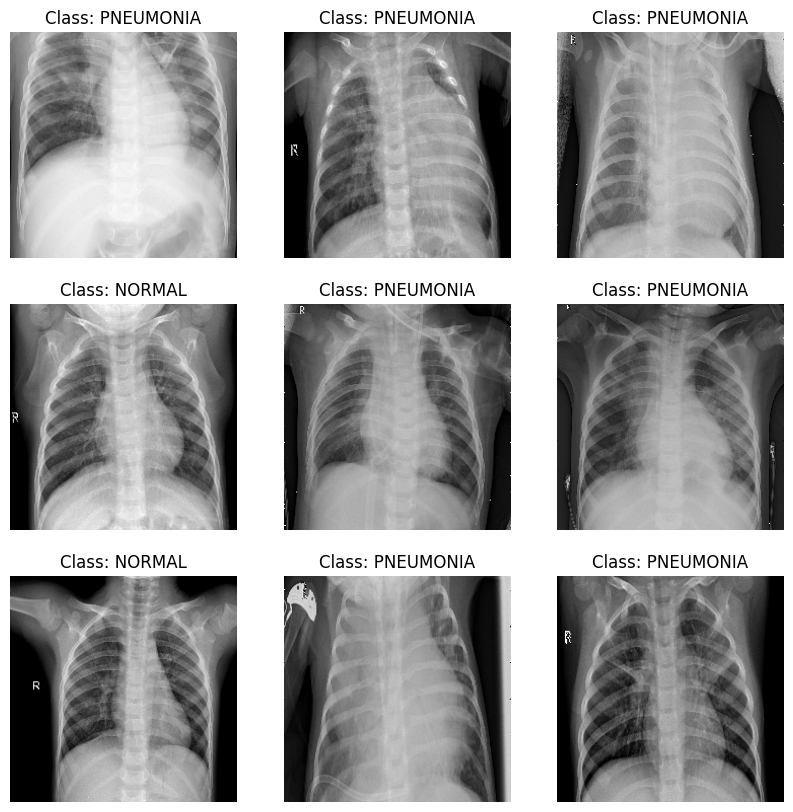

2025-08-06 20:52:41.367875: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# вывод 9 фотографий из датасета для примера
class_names = df_train.class_names
print("Классы:", class_names)

for images, labels in df_train.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray') 
        plt.title(f"Class: {class_names[int(labels[i].numpy().item())]}")
        plt.axis("off")
    plt.show()

___
    Исходная валидационная выборка df_valid содержит всего 16 изображений.
    Оценка качества модели на 16 изображениях ненадежна.
    Чтобы решить эту проблему, мы объединим df_train и df_valid выборки, а затем создаем новое разделение в пропорции 80/20.
___

In [7]:
# т.к. 16 изображений валидационной выборки - это очень мало, то объединим test с val, а потом разобьем их
df_train_full = df_train.concatenate(df_valid)
val_size = int(len(df_train_full) * 0.2)

df_valid = df_train_full.take(val_size)
df_train = df_train_full.skip(val_size)

print(f"Новый размер train (батчей): {len(df_train)}")
print(f"Новый размер valid (батчей): {len(df_valid)}")

Новый размер train (батчей): 132
Новый размер valid (батчей): 32


___

    Чтобы сделать модель более устойчивой к различным вариациям данных и для борьбы с переобучением, мы применяем аугментацию к тренировочным данным. 
    Используем преобразования:
    - Случайный поворот
    - Случайный сдвиг
    - Случайный зум

    Нормализация будет производиться непосредственно внутри модели с помощью слоя Rescaling.
___

In [8]:
# настроим аугментацию
# 1. будем поворачивать фотографии, на 10 градусов в разные стороны
# 2. смещаем фотографии по вертикали и горизонатли на 10 процентов
# 3. зумим фотографии на 20 процентов
data_augmentation_pipeline = tf.keras.Sequential([
    RandomRotation(factor=10/360.0, fill_mode="nearest", interpolation="bilinear"),
    RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="nearest", interpolation="bilinear"),
    RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest", interpolation="bilinear")
])

# Функция аугментации
def augment_images(image, label):
    return data_augmentation_pipeline(image, training=True), label

df_train_processed = df_train.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_valid_processed = df_valid.prefetch(tf.data.AUTOTUNE)
df_test_processed = df_test.prefetch(tf.data.AUTOTUNE)

___
    Проверим дисбаланс классов  
___

In [9]:
labels = np.concatenate([labels.numpy() for _, labels in df_train_processed])

unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique, counts))
normal_count = class_counts.get(0, 0)
pneumonia_count = class_counts.get(1, 0)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1073 изображений
Класс PNEUMONIA (1): 3135 изображений


2025-08-06 20:52:45.070960: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


___
    В датасете сильный дисбаланс классов
    Изображений с пневмонией почти в 3 раза больше, чем здоровых
___

# Разработка модели

___
    Для решения проблемы дисбаланса мы используем class_weight. 
    Рассчитаем веса, обратно пропорциональные частоте встречаемости каждого класса
___

In [10]:
# рассчитаем class_weights
# сделаем это через кол-во элементов одного и второго класса
total_count = len(labels)

weight_for_0 = (1 / normal_count) * (total_count / 2)
weight_for_1 = (1 / pneumonia_count) * (total_count / 2)

class_weights = {0: weight_for_0, 1: weight_for_1}

print(f'Веса normal: {weight_for_0}, пневмония: {weight_for_1}')

Веса normal: 1.9608574091332711, пневмония: 0.6711323763955342


___
    В ходе проекта были протестированы различные подходы и наиболее стабильные результаты показала модель, построенная с нуля.
    Что используем в модели:
    - Слой Rescaling в начале
    - Первый слой Conv2D для начального извлечения признаков, а более глубокие слои используют SeparableConv2D
    - Количество фильтров увеличивается с глубиной сети, а пространственный размер карт признаков уменьшается с помощью MaxPool2D
    - В голове модели используются несколько Dense слоев с BatchNormalization и сильным Dropout для предотвращения переобучения
___

In [11]:
# создадим модель
model = Sequential()

model.add(Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(SeparableConv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

model.add(SeparableConv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(learning_rate=1e-4), 
    metrics=[
        'accuracy',       
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
model.summary()

/home/koziy/projects/xray_env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 112, 112, 64)   │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 56, 56, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 28, 28, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,02

 Total params: 25,872,993 (98.70 MB)

 Trainable params: 25,870,497 (98.69 MB)

 Non-trainable params: 2,496 (9.75 KB)

___
    Обучим модель на 20 эпохах
    Для контроля и оптимизации процесса используем коллбэки:
    - ModelCheckpoint. Сохраняет лучшую версию модели.
    - EarlyStopping. Автоматически останавливает обучение, если производительность на валидационной выборке не улучшается в течение 5 эпох.
    - ReduceLROnPlateau. Снижает скорость обучения, если модель выходит на плато.
___

In [12]:
# используем коллбэки
# 1. Настройка learning rate при обучении
# 2. Сохранение лучшей версии модели
# 3. Остановка обучения, если нет улучшений
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    df_train_processed,
    validation_data=df_valid_processed,
    class_weight=class_weights,
    epochs=20,
    callbacks=[reduce_lr, model_checkpoint, early_stopping]
)

Epoch 1/20


I0000 00:00:1754502768.761051   37668 service.cc:152] XLA service 0x796518002b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754502768.761079   37668 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-08-06 20:52:48.933132: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754502769.481654   37668 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-06 20:52:52.369804: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv %cudnn-conv.17 = (f32[32,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0} %bitcast.18661, f32[32,1,3,3]{3,2,1,0} %bitcast.16841), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", metadata={op_type="Depthw

  1/132 ━━━━━━━━━━━━━━━━━━━━ 1:27:25 40s/step - accuracy: 0.5312 - auc: 0.5200 - loss: 1.2698 - precision: 0.8125 - recall: 0.5200

I0000 00:00:1754502805.516641   37668 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7715 - auc: 0.8923 - loss: 0.4800 - precision: 0.9585 - recall: 0.7241

2025-08-06 20:53:45.578045: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv %cudnn-conv.17 = (f32[16,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,112,112]{3,2,1,0} %bitcast.18661, f32[32,1,3,3]{3,2,1,0} %bitcast.16841), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNative" op_name="sequential_1_1/separable_conv2d_1/separable_conv2d/depthwise" source_file="/home/koziy/projects/xray_env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-08-06 20:53:46.659197: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7717 - auc: 0.8926 - loss: 0.4794 - precision: 0.9586 - recall: 0.7244

132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 297ms/step - accuracy: 0.7720 - auc: 0.8928 - loss: 0.4788 - precision: 0.9586 - recall: 0.7247 - val_accuracy: 0.7275 - val_auc: 0.5000 - val_loss: 0.6259 - val_precision: 0.7275 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.8625 - auc: 0.9620 - loss: 0.2879 - precision: 0.9821 - recall: 0.8301 - val_accuracy: 0.7363 - val_auc: 0.5085 - val_loss: 1.2262 - val_precision: 0.7363 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8886 - auc: 0.9700 - loss: 0.2491 - precision: 0.9804 - recall: 0.8681
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
132/132 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - accuracy: 0.8885 - auc: 0.9700 - loss: 0.2492 - precision: 0.9804 - recall: 0.8681 - val_accuracy: 0.7197 - val_auc: 0.5000 - val_loss: 2.2117 - val_precision: 0.7197 - val_recall: 1.0000 - learning_rate

132/132 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.8981 - auc: 0.9701 - loss: 0.2369 - precision: 0.9790 - recall: 0.8825 - val_accuracy: 0.8994 - val_auc: 0.9789 - val_loss: 0.2257 - val_precision: 0.8858 - val_recall: 0.9893 - learning_rate: 2.0000e-05
Epoch 6/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9138 - auc: 0.9788 - loss: 0.2025 - precision: 0.9864 - recall: 0.8974

132/132 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - accuracy: 0.9137 - auc: 0.9788 - loss: 0.2027 - precision: 0.9864 - recall: 0.8972 - val_accuracy: 0.9609 - val_auc: 0.9914 - val_loss: 0.1433 - val_precision: 0.9904 - val_recall: 0.9561 - learning_rate: 2.0000e-05
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.9233 - auc: 0.9787 - loss: 0.1967 - precision: 0.9837 - recall: 0.9122 - val_accuracy: 0.9551 - val_auc: 0.9907 - val_loss: 0.1684 - val_precision: 0.9943 - val_recall: 0.9431 - learning_rate: 2.0000e-05
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9203 - auc: 0.9769 - loss: 0.2047 - precision: 0.9815 - recall: 0.9095
Epoch 8: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.9203 - auc: 0.9769 - loss: 0.2047 - precision: 0.9815 - recall: 0.9094 - val_accuracy: 0.9561 - val_auc: 0.9897 - val_loss: 0.1640 - val_precision: 0.9875 - val_recall: 0.9519 - learning_rate: 2.

# Анализ результатов

___
    Выведем графики точности и потерь
___

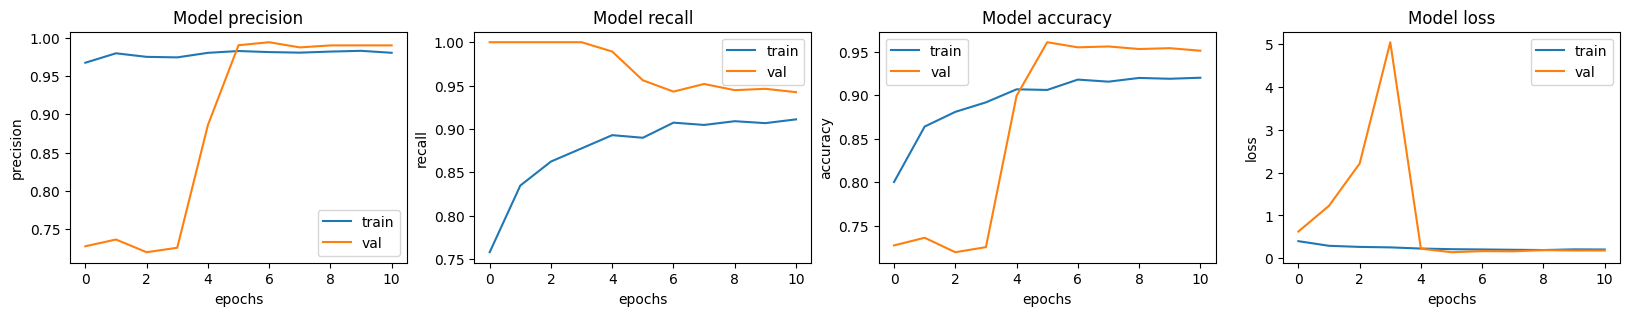

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

___

    Графики точности и потерь показывают:
    - Кривая Train Accuracy стабильно растет, а Train Loss падает.
    - Кривые Validation Accuracy и Validation Loss следуют за тренировочными, достигают своего оптимума, а затем начинают ухудшаться - это начало переобучения. 
    Коллбэк EarlyStopping остановил обучение, а ModelCheckpoint сохранил модель в ее пиковой производительности.
___

___
    Проведем финальную оценку на тестовой выборке, которую модель никогда не видела в процессе обучения или валидации
___

In [14]:
# проверим модель на тесте
results = model.evaluate(df_test_processed)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8121 - auc: 0.6144 - loss: 0.4967 - precision: 0.4625 - recall: 0.6515    
Test Loss: 0.3358907699584961
Test Accuracy: 0.875


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


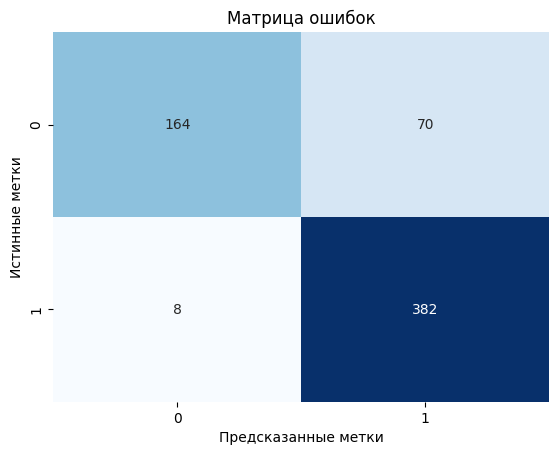

              precision    recall  f1-score   support

      NORMAL       0.95      0.70      0.81       234
   PNEUMONIA       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



In [15]:
# сделаем матрицу ошибок
y_pred_proba = model.predict(df_test_processed)
y_pred = (y_pred_proba > 0.5).astype('int32')
y_true = np.concatenate([y for x, y in df_test_processed], axis=0)


cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

___
    - Общая точность модели достигла ~88% на тестовых данных.
    - Recall для класса PNEUMONIA составляет 98%. Модель успешно идентифицировала 98% всех реально больных пациентов. False Negative является опасной ошибкой.
    - Precision для класса NORMAL составляет 95%. Если модель ставит диагноз "здоров", она почти всегда права
___

In [16]:
# получим изображения для вывода
images = []
for x, _ in df_test_processed.unbatch():
    images.append(x.numpy())

images = np.array(images)

fp_indices = np.where((y_pred == 1) & (y_true == 0))[0]
fn_indices = np.where((y_pred == 0) & (y_true == 1))[0]

2025-08-06 20:56:46.660715: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


___
    Визуализируем ошибочные предсказания, чтобы лучше понять слабые стороны модели
    - Здоровые пациенты, ошибочно классифицированные как больные
    - Больные пациенты, ошибочно классифицированные как здоровые. Модель делает очень мало таких ошибок, и это случаи с очень слабо выраженными признаками пневмонии
___

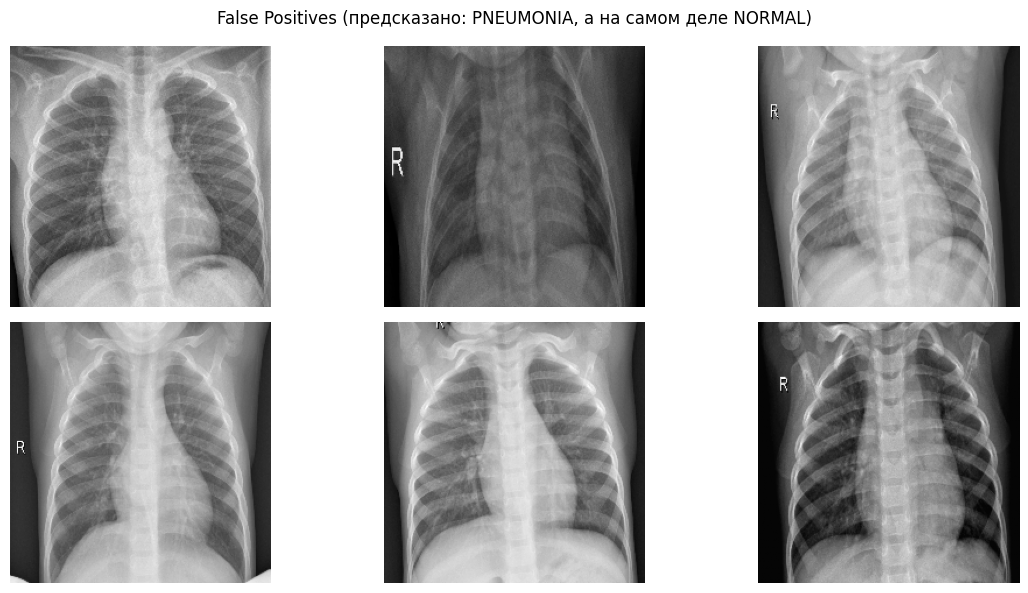

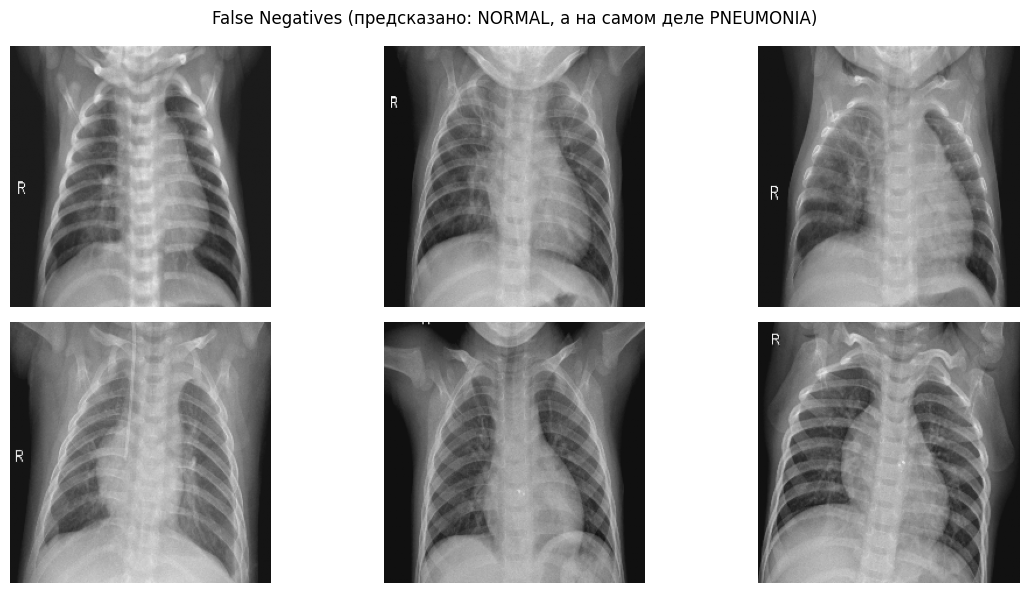

In [17]:
# функция вывода изображения
def show_errors(indices, title, num=6):
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(indices[:num]):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_errors(fp_indices, "False Positives (предсказано: PNEUMONIA, а на самом деле NORMAL)")
show_errors(fn_indices, "False Negatives (предсказано: NORMAL, а на самом деле PNEUMONIA)")

# Итоговый вывод

___
    В ходе проекта была разработана и обучена сверточная нейронная сеть для классификации рентгеновских снимков грудной клетки на наличие пневмонии.

    Выводы:
    1.  Модель, построенная с нуля показала значительно лучшие и более стабильные результаты, чем подходы с использованием более сложных предобученных архитектур.
    2.  Правильная подготовка данных и борьба с дисбалансом были важны для достижения высокого качества модели.
    3.  Финальная модель достигла 98% полноты по классу "Пневмония", минимизируя количество опасных ложноотрицательных срабатываний; а также достигла 88% точности, что делает ее потенциально полезным инструментом для помощи врачам-диагностам.

    Возможные дальнейшие улучшения:
    - Подбор порога классификации: Построение Precision-Recall кривой для выбора оптимального порога, который может еще лучше сбалансировать precision и recall.
    - Оптимизация гиперпараметров: Систематический подбор параметров.
___
